# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

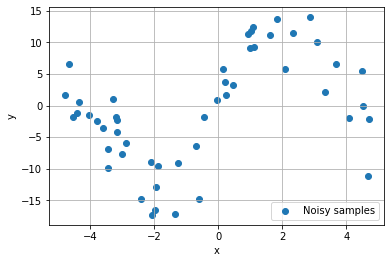

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

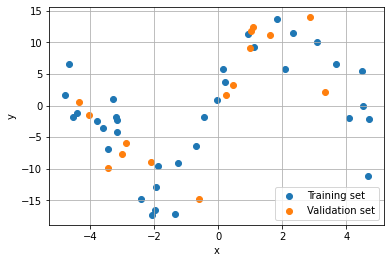

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [8]:
PolynomialFeatures(degree=4, include_bias=True).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.,   1.],
       [  1.,   3.,   9.,  27.,  81.],
       [  1.,   4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

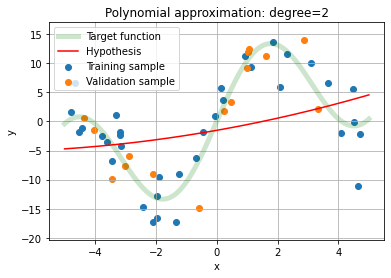

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

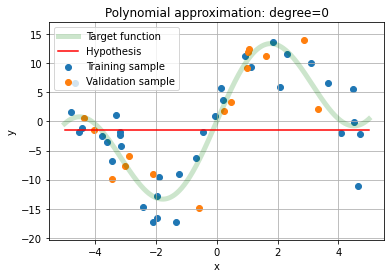

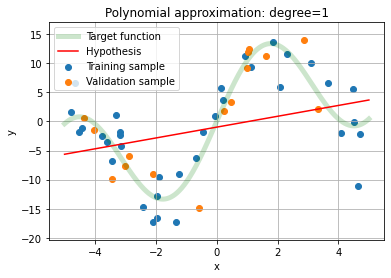

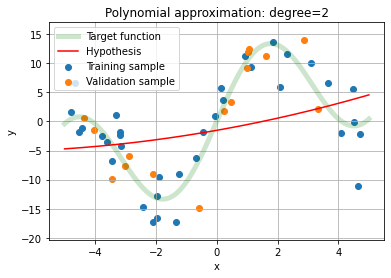

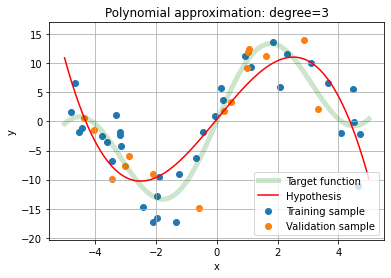

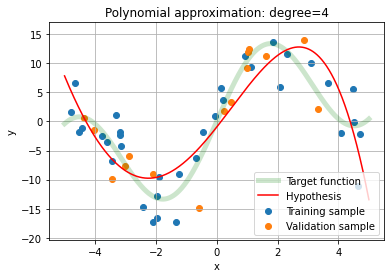

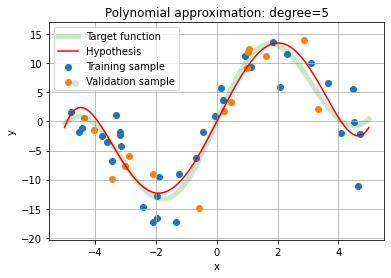

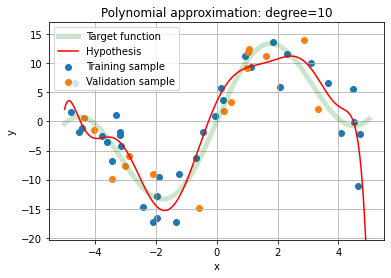

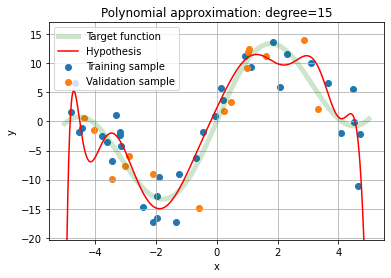

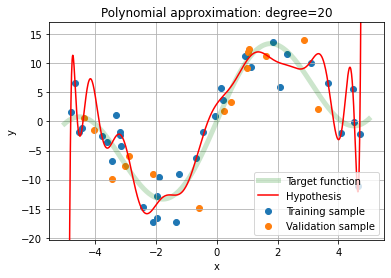

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

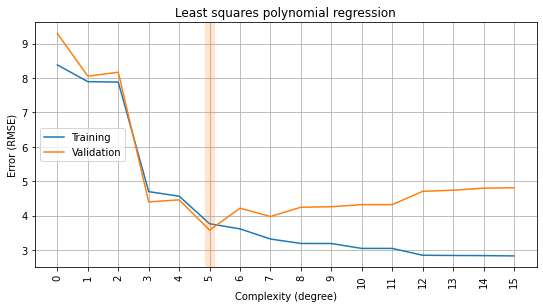

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, scale="linear", 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')
    plt.yscale(scale)
    if scale == "log":
        plt.legend(loc='lower left')
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

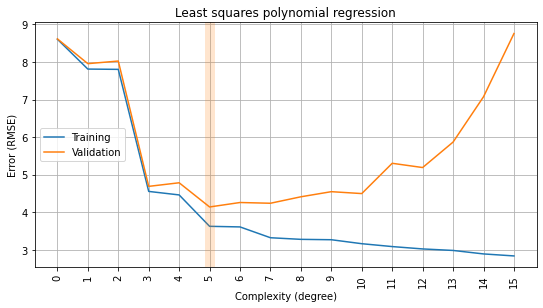

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

In [16]:
results

{'fit_time': array([0.00199509, 0.00199437, 0.00299144, 0.00199389, 0.00199556]),
 'score_time': array([0.00199389, 0.00099707, 0.00099754, 0.00099754, 0.        ]),
 'test_score': array([ -6.74084198, -15.45249378,  -4.18481146,  -5.5133313 ,
        -11.88775562]),
 'train_score': array([-2.79873909, -2.73756791, -3.15347496, -2.71684366, -2.78307021])}

### Model coefficients

Let's inspect our regression model coefficients:

In [17]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

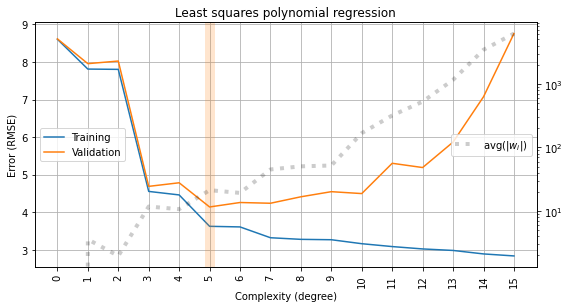

In [18]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

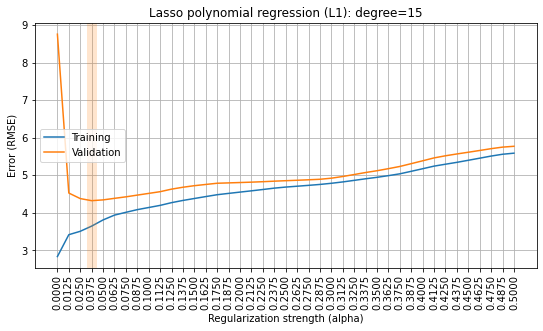

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

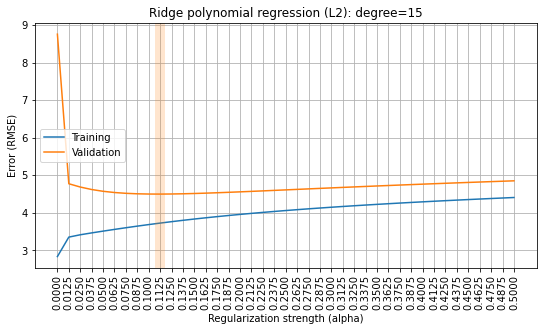

In [20]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

<b>WARNING!</b>

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you must collect all features together (those which were used to generate polynomials and the rest).


### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [21]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [22]:
X_diabetes.head() #look at our data

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [23]:
#train test split
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

Let's plot the corr table and take a subset of features to make polynoms, because 10 features it's too much for 15 degree 

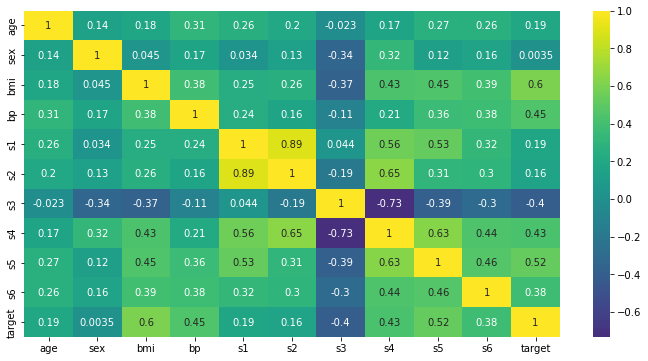

In [24]:
corr_table = pd.concat([X_train, y_train], axis=1).corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr_table, annot=True, center=0, cmap="viridis");

In [25]:
features_to_poly = ["bmi", "bp", "s4", "s5"]  #will make polynoms only of this features

In [26]:
features_wo_poly = ["age", "sex", "s1", "s2", "s3", "s6"] #will not make polynoms of this features

We needed to remake initial function make_model, to make possible transform only needed features.
We will do it with sklearn.compose.ColumnTransformer 

In [27]:
from sklearn.compose import ColumnTransformer

In [28]:
def make_model_with_transform(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    col_transformer = ColumnTransformer(
            [("poly_transform", PolynomialFeatures(degree, include_bias=(degree == 0)), features_to_poly),
            ("no_tranform", PolynomialFeatures(1, include_bias=False), features_wo_poly)])
    
    return Pipeline([
        ('col_transformer', col_transformer),        
        ('reg', regressor)
    ])

Let's doing cross validation with 5 folds split

In [29]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES[1:]:
    results = cross_validate(make_model_with_transform(degree),
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))

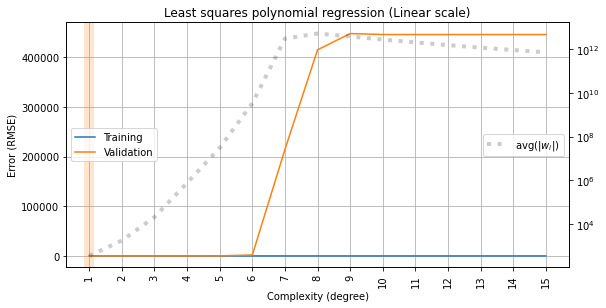

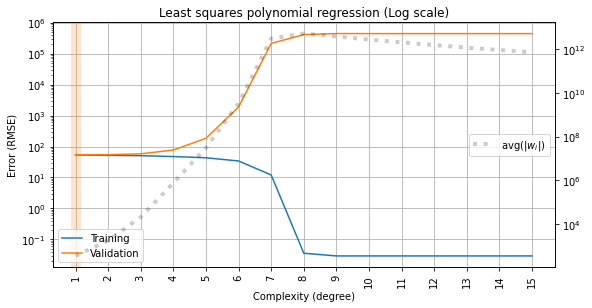

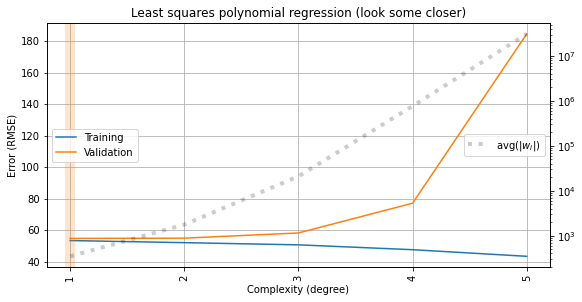

In [30]:
#plot in linear scale
plot_fitting_graph(DEGREES[1:], rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression (Linear scale)')

#plot in log scale
plot_fitting_graph(DEGREES[1:], rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression (Log scale)', scale="log")

#plot degrees 1 to 5
plot_fitting_graph(DEGREES[1:6], rmse_train[:5], rmse_valid[:5],
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef[:5], custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression (look some closer)')

In [31]:
#look in the table view
pd.DataFrame(data = {"Complexity":DEGREES[1:],
                     "Train_err": rmse_train, 
                     "Validation_err": rmse_valid,
                     "Average weights": avg_coef},     
            ).set_index("Complexity")

,Train_err,Validation_err,Average weights
Complexity,,,
1,53.341473,54.691714,3.459761e+02
2,51.993098,54.854529,1.757224e+03
3,50.608189,58.144938,2.084096e+04
4,47.526645,77.038347,7.636715e+05
5,43.329754,184.529796,3.091631e+07
6,34.120610,1886.054729,3.369925e+09
7,12.062650,214298.395581,3.084402e+12
8,0.035702,414657.418843,5.244450e+12
9,0.029186,447481.998244,3.843590e+12


In [32]:
#best degree
DEGREES[1:16][np.argmin(rmse_valid)]

1

### Summary Excercise 1
We make a models with different degrees of polynomial features. We see that the best complexity is equals 1 with our subset of features. With complexity more than 2 our model begins to overfit, and from value 6 we got a really huge errors on validation data. The train error is going closer to zero with increasing complexity (overfitting) 

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [33]:
l1_rmse_train, l1_rmse_valid, l1_avg_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_with_transform(degree=15, penalty='L1', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    l1_rmse_train.append(-np.mean(results['train_score']))
    l1_rmse_valid.append(-np.mean(results['test_score']))
    l1_avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))

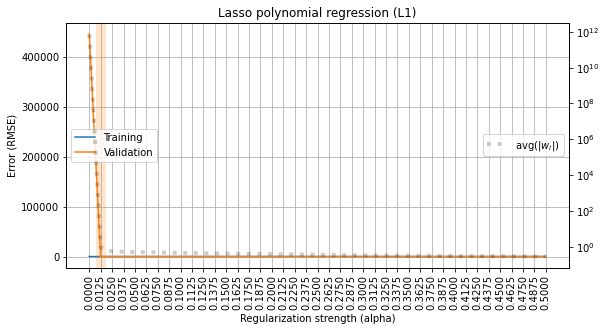

In [34]:
plot_fitting_graph(ALPHAS, l1_rmse_train, l1_rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=l1_avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1)')

Let's look closer without alpha = 0

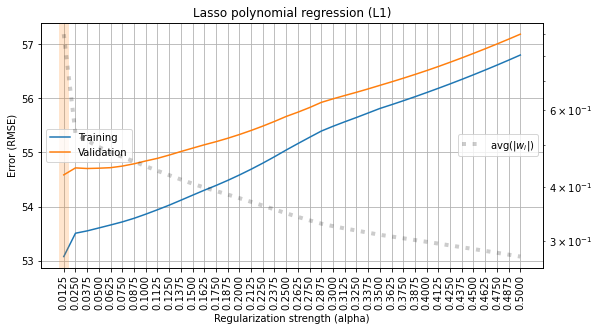

In [35]:
plot_fitting_graph(ALPHAS[1:], l1_rmse_train[1:], l1_rmse_valid[1:],
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=l1_avg_coef[1:], custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1)')

Let's look dependity of weights sizes and alpha

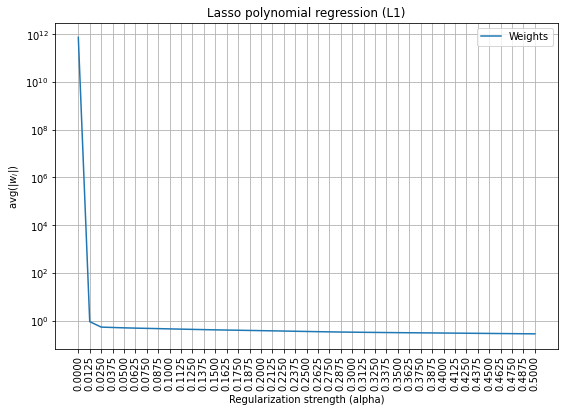

In [36]:
plt.figure(figsize=(9, 6))
plt.plot(ALPHAS, l1_avg_coef, label='Weights')
plt.xlabel("Regularization strength (alpha)")   
plt.ylabel('avg(|$w_i$|)')  
plt.title("Lasso polynomial regression (L1)")    
plt.grid(True)
plt.xticks(ALPHAS, rotation='vertical')
plt.legend(loc='upper right')
plt.yscale("log");

In [37]:
#look in the table view
l1_results = pd.DataFrame(data = {"Alpha":ALPHAS,
                     "L1_Train_err": l1_rmse_train, 
                     "L1_Validation_err": l1_rmse_valid,
                     "L1_Average weights": l1_avg_coef},     
            ).set_index("Alpha")
l1_results.head(10)

,L1_Train_err,L1_Validation_err,L1_Average weights
Alpha,,,
0.0000,0.029192,445511.418803,7.288351e+11
0.0125,53.073756,54.585626,8.983301e-01
0.0250,53.505557,54.714553,5.303562e-01
0.0375,53.548973,54.703251,5.111432e-01
0.0500,53.603462,54.708984,4.938100e-01
0.0625,53.658189,54.718717,4.803374e-01
0.0750,53.715140,54.747993,4.688714e-01
0.0875,53.781513,54.790370,4.575576e-01
0.1000,53.858003,54.842914,4.462428e-01


#### L2

In [38]:
l2_rmse_train, l2_rmse_valid, l2_avg_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_with_transform(degree=15, penalty='L2', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    l2_rmse_train.append(-np.mean(results['train_score']))
    l2_rmse_valid.append(-np.mean(results['test_score']))
    l2_avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))

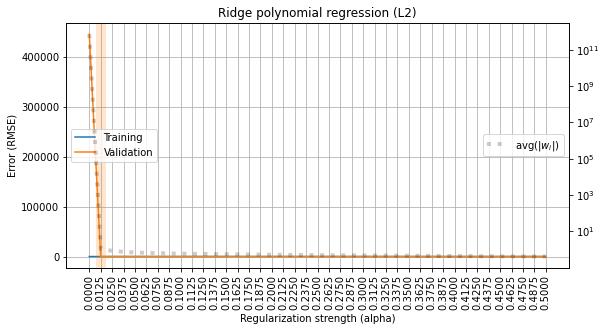

In [39]:
plot_fitting_graph(ALPHAS, l2_rmse_train, l2_rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=l2_avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2)')

Let's look closer without alpha = 0

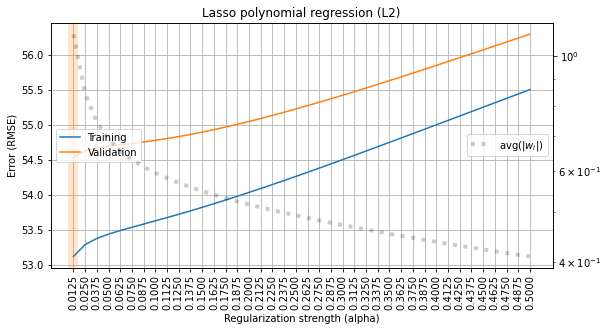

In [40]:
plot_fitting_graph(ALPHAS[1:], l2_rmse_train[1:], l2_rmse_valid[1:],
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=l2_avg_coef[1:], custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L2)')

Let's look dependity of weights sizes and alpha

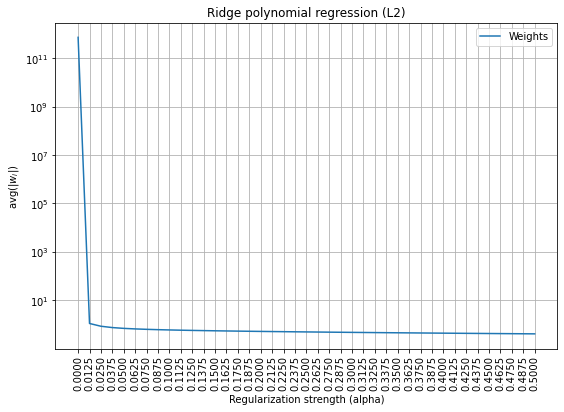

In [41]:
plt.figure(figsize=(9, 6))
plt.plot(ALPHAS, l2_avg_coef, label='Weights')
plt.xlabel("Regularization strength (alpha)")   
plt.ylabel('avg(|$w_i$|)')  
plt.title("Ridge polynomial regression (L2)")    
plt.grid(True)
plt.xticks(ALPHAS, rotation='vertical')
plt.legend(loc='upper right')
plt.yscale("log");

In [42]:
#look in the table view
l2_results = pd.DataFrame(data = {"Alpha":ALPHAS,
                     "L2_Train_err": l2_rmse_train, 
                     "L2_Validation_err": l2_rmse_valid,
                     "L2_Average weights": l2_avg_coef},     
            ).set_index("Alpha")
l2_results.head(10)

,L2_Train_err,L2_Validation_err,L2_Average weights
Alpha,,,
0.0000,0.029192,445511.418803,7.288351e+11
0.0125,53.123479,54.535695,1.100237e+00
0.0250,53.294122,54.627919,8.455023e-01
0.0375,53.381565,54.668466,7.454648e-01
0.0500,53.442790,54.693529,6.905184e-01
0.0625,53.493833,54.714058,6.559494e-01
0.0750,53.540820,54.734162,6.306104e-01
0.0875,53.586502,54.755566,6.107691e-01
0.1000,53.632223,54.779018,5.945439e-01


#### Summary

Let's compare differences between L1 and L2 regularizations

Look how changes the weigths in depending on regularization type

In [43]:
l1_results[["L1_Average weights"]].join(l2_results[["L2_Average weights"]]).T

Alpha,0.0000,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,...,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
L1_Average weights,7.288351e+11,0.898330,0.530356,0.511143,0.493810,0.480337,0.468871,0.457558,0.446243,0.435558,...,0.301772,0.298940,0.296120,0.293315,0.290510,0.287704,0.284900,0.282094,0.279290,0.276484
L2_Average weights,7.288351e+11,1.100237,0.845502,0.745465,0.690518,0.655949,0.630610,0.610769,0.594544,0.580809,...,0.441630,0.437779,0.434031,0.430383,0.426827,0.423353,0.419953,0.416624,0.413361,0.410163


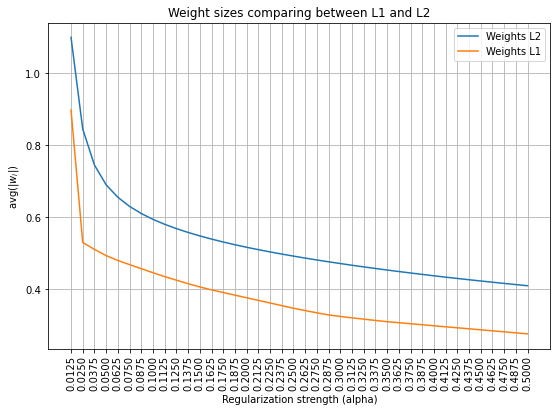

In [44]:
plt.figure(figsize=(9, 6))
plt.plot(ALPHAS[1:], l2_avg_coef[1:], label='Weights L2')
plt.plot(ALPHAS[1:], l1_avg_coef[1:], label='Weights L1')
plt.xlabel("Regularization strength (alpha)")   
plt.ylabel('avg(|$w_i$|)')  
plt.title("Weight sizes comparing between L1 and L2")    
plt.grid(True)
plt.xticks(ALPHAS[1:], rotation='vertical')
plt.legend(loc='upper right');

Look how changes RMSE metric in depending on regularization type

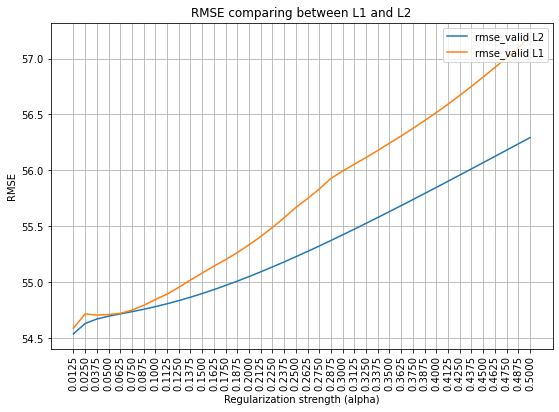

In [45]:
plt.figure(figsize=(9, 6))
plt.plot(ALPHAS[1:], l2_rmse_valid[1:], label='rmse_valid L2')
plt.plot(ALPHAS[1:], l1_rmse_valid[1:], label='rmse_valid L1')
plt.xlabel("Regularization strength (alpha)")   
plt.ylabel('RMSE')  
plt.title("RMSE comparing between L1 and L2")    
plt.grid(True)
plt.xticks(ALPHAS[1:], rotation='vertical')
plt.legend(loc='upper right');

#### With both regularizations types we have constrainting of the weights. But with L1 it's more powerfully weigth decreasing. L2 gives us a little better RMSE metric on the test set

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [46]:
l1_weights = []
for alpha in ALPHAS:    
    reg = make_model_with_transform(degree=15, penalty='L1', alpha=alpha) 
    reg.fit(X_diabetes, y_diabetes)
    l1_weights.append(reg["reg"].coef_)
all_weights = l1_weights[0].size

Let's count how much zero weights we have

In [47]:
zeros = []
non_zeros = []
for i in range(len(l1_weights)):
    zeros.append(l1_weights[i][np.where(l1_weights[i] == 0)].size)
    non_zeros.append(all_weights - zeros[i])

Let's plot it

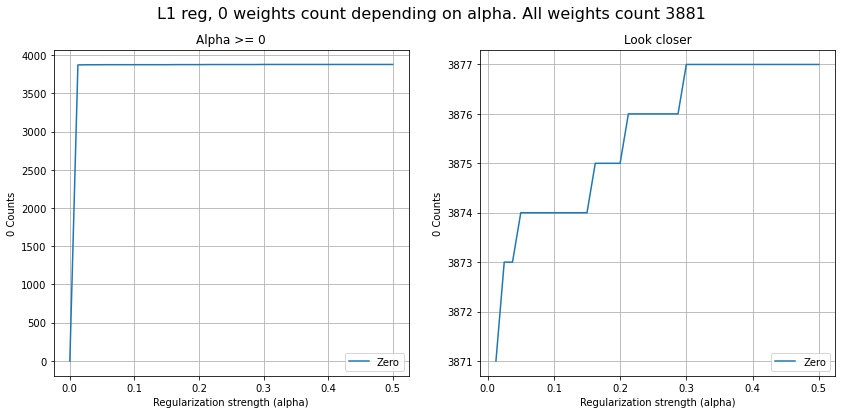

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f"L1 reg, 0 weights count depending on alpha. All weights count {all_weights}", fontsize=16)
ax1.plot(ALPHAS, zeros, label='Zero')
ax1.set_xlabel("Regularization strength (alpha)")   
ax1.set_ylabel('0 Counts')  
ax1.set_title("Alpha >= 0")    
ax1.grid(True)
ax1.legend(loc='lower right')
ax2.plot(ALPHAS[1:], zeros[1:], label='Zero')
ax2.set_xlabel("Regularization strength (alpha)")   
ax2.set_ylabel('0 Counts')  
ax2.set_title("Look closer")    
ax2.grid(True)
ax2.legend(loc='lower right');


Let's plot non-zero weights

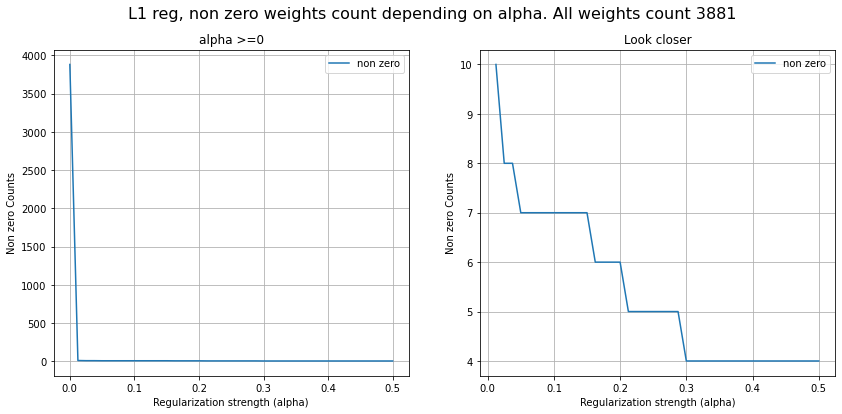

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f"L1 reg, non zero weights count depending on alpha. All weights count {all_weights}", fontsize=16)
ax1.plot(ALPHAS, non_zeros, label='non zero')
ax1.set_xlabel("Regularization strength (alpha)")   
ax1.set_ylabel('Non zero Counts')  
ax1.set_title("alpha >=0")    
ax1.grid(True)
ax1.legend(loc='upper right')
ax2.plot(ALPHAS[1:], non_zeros[1:], label='non zero')
ax2.set_xlabel("Regularization strength (alpha)")   
ax2.set_ylabel('Non zero Counts')  
ax2.set_title("Look closer")    
ax2.grid(True)
ax2.legend(loc='upper right');

#### L2

In [50]:
l2_weights = []
for alpha in ALPHAS:    
    reg = make_model_with_transform(degree=15, penalty='L2', alpha=alpha) 
    reg.fit(X_diabetes, y_diabetes)
    l2_weights.append(reg["reg"].coef_)
all_weights = l2_weights[0].size

In [51]:
zeros = []
non_zeros = []
for i in range(len(l2_weights)):
    zeros.append(l2_weights[i][np.where(l2_weights[i] == 0)].size)
    non_zeros.append(all_weights - zeros[i])

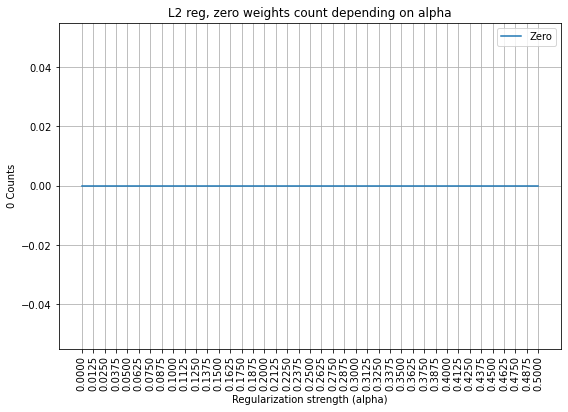

In [52]:
plt.figure(figsize=(9, 6))
plt.plot(ALPHAS, zeros, label='Zero')
plt.xlabel("Regularization strength (alpha)")   
plt.ylabel('0 Counts')  
plt.title("L2 reg, zero weights count depending on alpha")    
plt.grid(True)
plt.xticks(ALPHAS, rotation='vertical')
plt.legend(loc='upper right');

#### Summary

#### We have compared the zero value counts in weights after L1 and L2 regularizations:
- In L1 we have got 3877 null weights with alpha = 0.5 and complexity degree = 15. And only 4 not-null. Almost all weights were been nulled.
- In L2 we doesn't have any 0 weights. It is still small weights, but not null.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [53]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


We will make two pipelines, one - with scaling, second - without. Also in study goals we will remove polynomic transformations, because with degree more than 5 and without scaling features, our regression will not convergence

In [54]:
def make_scaling_model(alpha=0, penalty=None):
    """make pipeline with 2 steps: standardscaler and regressor"""
    
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([        
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

In [55]:
def make_wo_scale_model(alpha=0, penalty=None):
    """make regressor model"""
    
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
        
    return regressor

#### L1

In [56]:
#calculate parameters without feature scaling
l1_notscale_rmse_train, l1_notscale_rmse_valid, l1_notscale_avg_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_wo_scale_model(penalty='L1', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    l1_notscale_rmse_train.append(-np.mean(results['train_score']))
    l1_notscale_rmse_valid.append(-np.mean(results['test_score']))
    l1_notscale_avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model.coef_))
            for model in results['estimator']
        ]))

In [57]:
#calculate parameters with feature scaling
l1_scale_rmse_train, l1_scale_rmse_valid, l1_scale_avg_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_scaling_model(penalty='L1', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    l1_scale_rmse_train.append(-np.mean(results['train_score']))
    l1_scale_rmse_valid.append(-np.mean(results['test_score']))
    l1_scale_avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model["reg"].coef_))
            for model in results['estimator']
        ]))

Plot the results

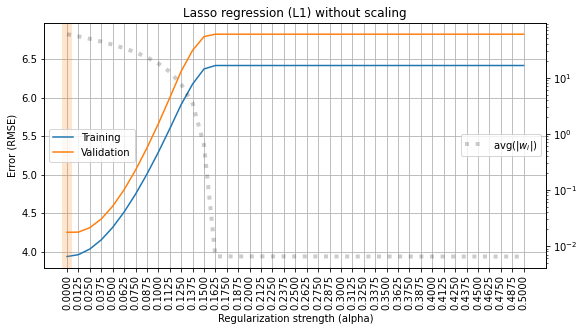

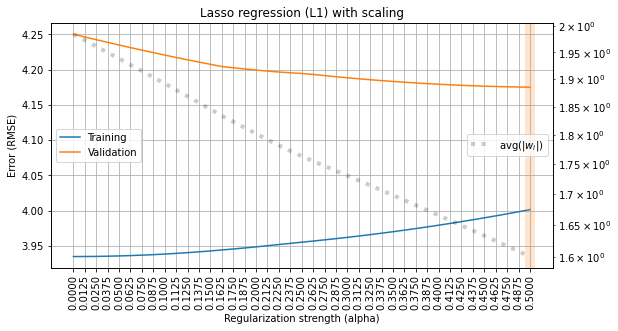

In [58]:
plot_fitting_graph(ALPHAS, l1_notscale_rmse_train, l1_notscale_rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=l1_notscale_avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso regression (L1) without scaling')
plot_fitting_graph(ALPHAS, l1_scale_rmse_train, l1_scale_rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=l1_scale_avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso regression (L1) with scaling')

#### L2

In [59]:
#calculate parameters without feature scaling
l2_notscale_rmse_train, l2_notscale_rmse_valid, l2_notscale_avg_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_wo_scale_model(penalty='L2', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    l2_notscale_rmse_train.append(-np.mean(results['train_score']))
    l2_notscale_rmse_valid.append(-np.mean(results['test_score']))
    l2_notscale_avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model.coef_))
            for model in results['estimator']
        ]))

In [60]:
#calculate parameters with feature scaling
l2_scale_rmse_train, l2_scale_rmse_valid, l2_scale_avg_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_scaling_model(penalty='L2', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    l2_scale_rmse_train.append(-np.mean(results['train_score']))
    l2_scale_rmse_valid.append(-np.mean(results['test_score']))
    l2_scale_avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model["reg"].coef_))
            for model in results['estimator']
        ]))

Plot the results


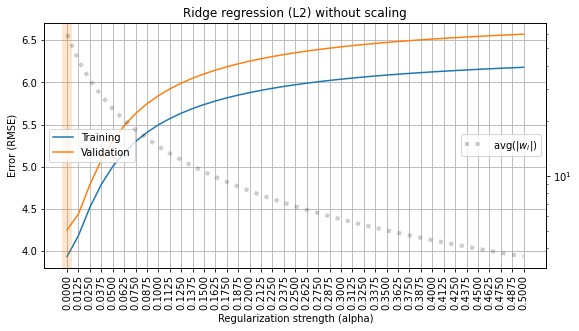

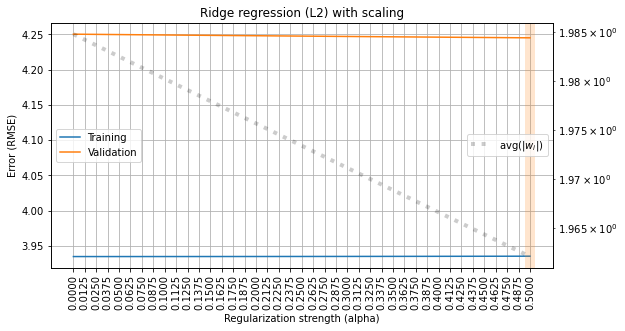

In [61]:
plot_fitting_graph(ALPHAS, l2_notscale_rmse_train, l2_notscale_rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=l2_notscale_avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge regression (L2) without scaling')
plot_fitting_graph(ALPHAS, l2_scale_rmse_train, l2_scale_rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=l2_scale_avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge regression (L2) with scaling')

Let's compare the weights of the models depending on feature scaling

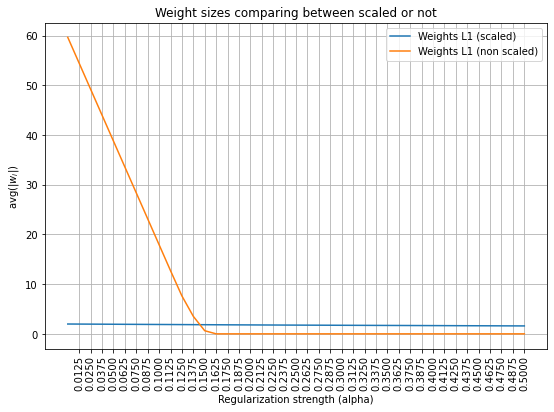

In [62]:
#L1
plt.figure(figsize=(9, 6))
plt.plot(ALPHAS, l1_scale_avg_coef, label='Weights L1 (scaled)')
plt.plot(ALPHAS, l1_notscale_avg_coef, label='Weights L1 (non scaled)')
plt.xlabel("Regularization strength (alpha)")   
plt.ylabel('avg(|$w_i$|)')  
plt.title("Weight sizes comparing between scaled or not")    
plt.grid(True)
plt.xticks(ALPHAS[1:], rotation='vertical')
plt.legend(loc='upper right');

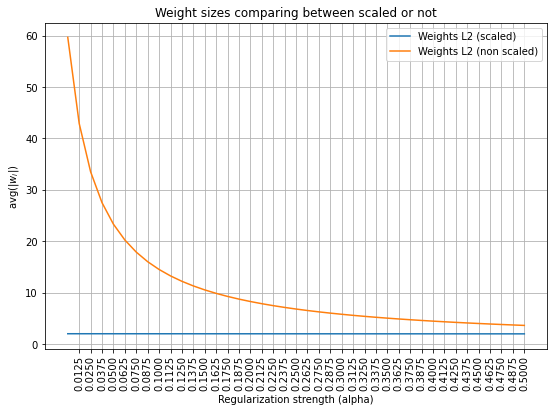

In [63]:
#L2
plt.figure(figsize=(9, 6))
plt.plot(ALPHAS, l2_scale_avg_coef, label='Weights L2 (scaled)')
plt.plot(ALPHAS, l2_notscale_avg_coef, label='Weights L2 (non scaled)')
plt.xlabel("Regularization strength (alpha)")   
plt.ylabel('avg(|$w_i$|)')  
plt.title("Weight sizes comparing between scaled or not")    
plt.grid(True)
plt.xticks(ALPHAS[1:], rotation='vertical')
plt.legend(loc='upper right');

#### Summary



Let's make a comparing tables for L1 and L2 with/without feature scaling

In [64]:
l1_results_scaled = pd.DataFrame(data = {"Alpha":ALPHAS,                     
                     "Error with scaling": l1_scale_rmse_valid,
                     "Weights with scaling": l1_scale_avg_coef},     
            ).set_index("Alpha")
l1_results_not_scaled = pd.DataFrame(data = {"Alpha":ALPHAS,                     
                     "Error without scaling": l1_notscale_rmse_valid,
                     "Weights without scaling": l1_notscale_avg_coef},     
            ).set_index("Alpha")
print("Comparing table for Lasso model")
l1_results_scaled.join(l1_results_not_scaled).T

Comparing table for Lasso model


Alpha,0.0000,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,...,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
Error with scaling,4.250279,4.246336,4.242461,4.238655,4.234918,4.231250,4.227651,4.224121,4.220661,4.217272,...,4.180159,4.179282,4.178483,4.177763,4.177122,4.176560,4.176077,4.175674,4.175351,4.175108
Weights with scaling,1.984767,1.973200,1.961634,1.950067,1.938500,1.926933,1.915366,1.903799,1.892233,1.880666,...,1.674243,1.666100,1.657957,1.649814,1.641671,1.633528,1.625385,1.617242,1.609098,1.600955
Error without scaling,4.250279,4.252740,4.310252,4.423323,4.589462,4.803253,5.057672,5.345633,5.660914,5.998422,...,6.825104,6.825088,6.825073,6.825057,6.825042,6.825026,6.825011,6.824995,6.824980,6.824964
Weights without scaling,59.654990,54.440902,49.226828,44.012755,38.798682,33.584609,28.370535,23.156560,17.942516,12.728485,...,0.006495,0.006493,0.006491,0.006489,0.006487,0.006486,0.006484,0.006482,0.006480,0.006478


In [65]:
l2_results_scaled = pd.DataFrame(data = {"Alpha":ALPHAS,                     
                     "Error with scaling": l2_scale_rmse_valid,
                     "Weights with scaling": l2_scale_avg_coef},     
            ).set_index("Alpha")
l2_results_not_scaled = pd.DataFrame(data = {"Alpha":ALPHAS,                     
                     "Error without scaling": l2_notscale_rmse_valid,
                     "Weights without scaling": l2_notscale_avg_coef},     
            ).set_index("Alpha")
print("Comparing table for Ridge model")
l2_results_scaled.join(l2_results_not_scaled).T

Comparing table for Ridge model


Alpha,0.0000,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,...,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
Error with scaling,4.250279,4.250135,4.249992,4.249850,4.249709,4.249568,4.249429,4.249290,4.249151,4.249014,...,4.246175,4.246055,4.245935,4.245816,4.245698,4.245580,4.245463,4.245347,4.245231,4.245116
Weights with scaling,1.984767,1.984195,1.983624,1.983052,1.982481,1.981911,1.981340,1.980770,1.980201,1.979631,...,1.967189,1.966627,1.966066,1.965505,1.964944,1.964383,1.963823,1.963263,1.962704,1.962145
Error without scaling,4.250279,4.439280,4.786926,5.079607,5.308091,5.487074,5.629758,5.745674,5.841492,5.921917,...,6.504329,6.513492,6.522147,6.530335,6.538093,6.545455,6.552449,6.559102,6.565440,6.571483
Weights without scaling,59.654990,42.896010,33.499785,27.484165,23.301769,20.225005,17.866471,16.000883,14.488280,13.237118,...,4.568232,4.436310,4.311803,4.194105,4.082671,3.977013,3.876695,3.781322,3.690536,3.604015


We have found empirically that is a very important to make feature scaling:
- Our models (both, L2 and L1) become more stable
- We get better RMSE result with scaling
- High complexity models not always can convergence without feature scaling
- In Lasso regression the weights tending to almost zero without scaling throughout alpha increasing, against stable weights with scaling 

<b>Summary: always do feature scaling before fitting the model. It will make it work better</b>